In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import atmosentry
from atmosentry.meteoroid import Meteoroid

matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

Many of the bulk properties of comets are, currently, quite poorely constrained. As such, it can be beneficial to characterise the uncertainty in models of their atmospheric entry to these model parameters. In this notebook, we demonstrate how to investigate the role of tensile strength, and bulk density in atmospheric entry.

In [2]:
def gen_impactor(sigma_imp=1e4, R0=250, rho_imp = 0.6e3):

    # impactor's heat of ablation, bulk density
    eta_imp = 2.5e6 # J/kg

    theta0 = 45. * np.pi / 180. # impact angle (radians)
    V0 = 20e3 # top-of-atmosphere impact velocity

    M0 = rho_imp * (4 * np.pi / 3) * (R0 ** 3) # initial mass

    impactor = Meteoroid(x=0,
                        y=0,
                        z=100e3,
                        vx=-V0 * np.cos(theta0),
                        vy=0,
                        vz=-V0 * np.sin(theta0),
                        radius=R0,
                        mass=M0,
                        sigma=sigma_imp,
                        rho=rho_imp,
                        eta=eta_imp)
    
    return impactor

### tensile strength

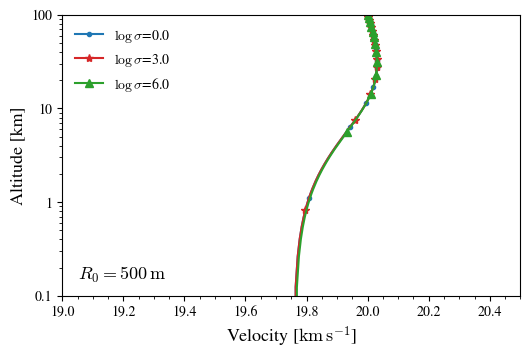

In [3]:
# here we set the tensile strength we want to test
sigma_ten = [1e0, 1e3, 1e6]
colors = ['tab:blue', 'tab:red', 'tab:green']
markers = ['.', '*', '^']
markerpoitns = [37, 47, 61]

_ = plt.figure(figsize=(5.91, 3.65))

for counter, sigma in enumerate(sigma_ten):

    sim = atmosentry.Simulation()

    impactor = gen_impactor(sigma, 500)
    sim.impactor = impactor

    sim.dt = 1e-2 # here you can set the maximum timestep of the simulation

    sim.integrate()

    vel = np.sqrt(sim.impactor.state.vx ** 2 + sim.impactor.state.vy ** 2 + sim.impactor.state.vz ** 2) / 1e3
    altitude = sim.impactor.state.z / 1e3

    plt.plot(vel, altitude, colors[counter], label=rf'$\log\sigma$={np.log10(sigma)}', marker=markers[counter], markevery=markerpoitns[counter])

    for frag in sim.fragments:
        vel = np.sqrt(frag.state.vx ** 2 + frag.state.vy ** 2 + frag.state.vz ** 2) / 1e3
        altitude = frag.state.z / 1e3
    
        plt.plot(vel, altitude, colors[counter], marker=markers[counter], markevery=markerpoitns[counter])

plt.yscale('log')

plt.xlim(19, 20.5)
plt.ylim(1e-1, 1e2)
plt.yticks([0.1, 1, 10, 100], labels=[0.1, 1, 10, 100])

plt.xlabel(r'Velocity [${\rm km\,s}^{-1}$]', fontsize=13)
plt.ylabel(r'Altitude [km]', fontsize=13)

plt.minorticks_on()

plt.text(19.05, .15, r'$R_0 = 500\,{\rm m}$', fontsize=13)

plt.legend(frameon=False, loc='upper left')

plt.show()

It is hopefully clear from above that tensile strength makes essentially no difference, even when going as low as 1Pa: this is driven by the characteristic deformation time, and the growth of hydrodynamic (Rayleigh-Taylor) instabilities. As we show below, these processes are very sensitive to the comet's bulk density, which accordingly has a large effect on its trajectory through the atmosphere.

### bulk density

Here we consider the mass, and energy deposition at constant radius: unlike tensile strength, this has a massive effect. There are two main factors that contribute to this sensitivity:
- At constant radius, the lower density comets will have a lower initial mass. Just by the conservation of momentum, we should therefore expect they are slowed more significantly by the presence of the atmosphere.
- After the ram pressure exceeds the comets' tensile strength, the comet begins to deform according to the following differential equation,

$$r\dfrac{d^2r}{dt^2} = \dfrac{C_D}{2}\left(\dfrac{\rho_{\rm atm}}{\rho_{\rm imp}}\right)v^2.$$

- The timescale of this deformation is proprtional to $\sqrt{\rho_{\rm imp}}$: low density comets will deform much faster than high density comets. This deformation increases its surface area, which in turn increases atmospheric drag, and mass ablation: mass ablation will be much more significant in the upper atmosphere.

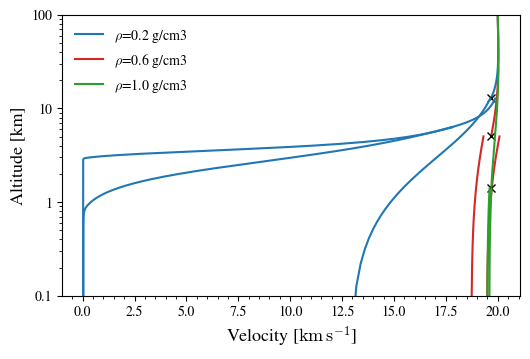

In [4]:
rho_bulk = np.array([0.2e3, 0.6e3, 1e3])
colors = ['tab:blue', 'tab:red', 'tab:green']

_ = plt.figure(figsize=(5.91, 3.65))

for counter, rho in enumerate(rho_bulk):

    M0 = rho * (4 * np.pi / 3) * (250 ** 3)

    sim = atmosentry.Simulation()

    impactor = gen_impactor(rho_imp=rho)
    sim.impactor = impactor

    sim.dt = 1e-2 # here you can set the maximum timestep of the simulation

    sim.integrate()

    vel = np.sqrt(sim.impactor.state.vx ** 2 + sim.impactor.state.vy ** 2 + sim.impactor.state.vz ** 2) / 1e3
    altitude = sim.impactor.state.z / 1e3

    plt.plot(vel, altitude, colors[counter], label=rf'$\rho$={rho / 1e3} g/cm3')
    plt.plot(vel[-1], altitude[-1], 'x', c='k')

    for frag in sim.fragments:
        vel = np.sqrt(frag.state.vx ** 2 + frag.state.vy ** 2 + frag.state.vz ** 2) / 1e3
        altitude = frag.state.z / 1e3
    
        plt.plot(vel, altitude, colors[counter])

plt.yscale('log')

plt.ylim(1e-1, 1e2)
plt.yticks([0.1, 1, 10, 100], labels=[0.1, 1, 10, 100])

plt.xlabel(r'Velocity [${\rm km\,s}^{-1}$]', fontsize=13)
plt.ylabel(r'Altitude [km]', fontsize=13)

plt.minorticks_on()

plt.legend(frameon=False, loc='upper left')

plt.show()

In [5]:
def calc_combined_fragment_deposition(sim):
    """
    Docstring: need to combine contribution from contributions at constant altitude... (rewrite)
    """
    
    altitudes = np.linspace(0, 100e3, 10000)
    cumulative_energy_deposition = np.zeros_like(altitudes)
    cumulative_mass_deposition = np.zeros_like(altitudes)

    for j, h in enumerate(altitudes):
        cumulative_dE = 0.0
        cumulative_dM = 0.0

        cumulative_dE += np.sum(sim.impactor.state.dEkin[sim.impactor.state.z >= h])
        cumulative_dM += np.sum(sim.impactor.state.dM[sim.impactor.state.z >= h])

        for fragment in sim.fragments:
            cumulative_dE += np.sum(fragment.state.dEkin[fragment.state.z >= h])
            cumulative_dM += np.sum(fragment.state.dM[fragment.state.z >= h])
        
        cumulative_energy_deposition[j] = cumulative_dE
        cumulative_mass_deposition[j] = cumulative_dM
    
    return altitudes, cumulative_energy_deposition, cumulative_mass_deposition

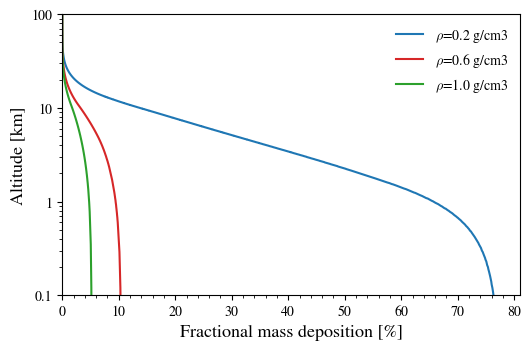

In [6]:
rho_bulk = np.array([0.2e3, 0.6e3, 1e3])
colors = ['tab:blue', 'tab:red', 'tab:green']

KE0 = 0.5 * M0 * (20e3 ** 2)

_ = plt.figure(figsize=(5.91, 3.65))

for counter, rho in enumerate(rho_bulk):

    M0 = rho * (4 * np.pi / 3) * (250 ** 3)

    sim = atmosentry.Simulation()

    impactor = gen_impactor(rho_imp=rho)
    sim.impactor = impactor

    sim.dt = 1e-3 # here you can set the maximum timestep of the simulation

    sim.integrate()

    altitudes, _, cumulative_mass_deposition = calc_combined_fragment_deposition(sim)

    plt.plot(cumulative_mass_deposition / M0 * 100, altitudes / 1e3, c=colors[counter], label=rf'$\rho$={rho / 1e3} g/cm3')

plt.yscale('log')

plt.xlim(0, )
plt.ylim(1e-1, 1e2)
plt.yticks([0.1, 1, 10, 100], labels=[0.1, 1, 10, 100])

plt.xlabel(r'Fractional mass deposition [%]', fontsize=13)
plt.ylabel(r'Altitude [km]', fontsize=13)

plt.minorticks_on()

plt.legend(frameon=False)

plt.show()

The example above is not a totally fair comparison: the lower density comets are less massive, and should therefore already be expected to be stopped, and fragmented by the same atmosphere. To demonstrate the rapid deformation, and fragmentation of high density comets, in the next example we keep the comet mass constant while varying its density.

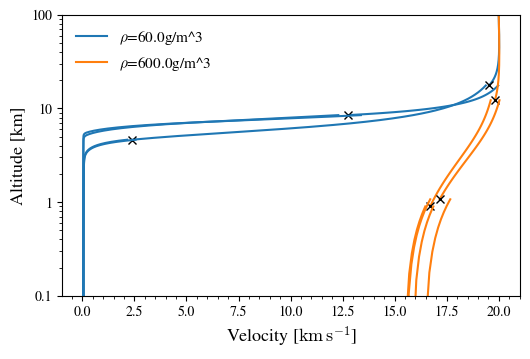

In [7]:
rho_com = 0.6e3
R0 = 150
theta0 = 45 * np.pi / 180
V0 = 20e3
M0 = rho_com * (4 * np.pi / 3) * (R0 ** 3)

rhos = [0.06e3, 0.6e3]
cols = ['tab:blue', 'tab:orange']

_ = plt.figure(figsize=(5.91, 3.65))

for counter, rho in enumerate(rhos):

    R0 = (3 * M0 / (4 * np.pi * rho)) ** (1/3)

    impactor = Meteoroid(x=0,
                        y=0,
                        z=100e3,
                        vx=-V0 * np.cos(theta0),
                        vy=0,
                        vz=-V0 * np.sin(theta0),
                        radius=R0,
                        mass=M0,
                        sigma=1e4,
                        rho=rho,
                        eta=2.5e6)

    sim = atmosentry.Simulation()

    sim.dt = 1e-2
    sim.impactor = impactor

    sim.integrate()

    vel = np.sqrt(sim.impactor.state.vx ** 2 + sim.impactor.state.vy ** 2 + sim.impactor.state.vz ** 2) / 1e3

    plt.plot(vel, sim.impactor.state.z / 1e3, c=cols[counter], label=rf'$\rho$={rho}g/m^3')
    plt.plot(vel[-1], sim.impactor.state.z[-1] / 1e3, 'x', c='k')

    for frag in sim.fragments:
        vel = np.sqrt(frag.state.vx ** 2 + frag.state.vy ** 2 + frag.state.vz ** 2) / 1e3

        plt.plot(vel, frag.state.z / 1e3, c=cols[counter])

        if frag.children:
            plt.plot(vel[-1], frag.state.z[-1] / 1e3, 'x', c='k')

plt.yscale('log')

plt.ylim(1e-1, 100)
plt.yticks([0.1, 1, 10, 100], labels=[0.1, 1, 10, 100])

plt.minorticks_on()

plt.xlabel(r'Velocity [${\rm km\,s}^{-1}$]', fontsize=13)
plt.ylabel(r'Altitude [km]', fontsize=13)

plt.legend(frameon=False, fontsize=11)

plt.show()